In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
from pathlib import Path

import re
from tqdm import tqdm

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

# for computing cosine sim
from numpy.linalg import norm

# data import

if data source is from test_data folder in the same directory

In [3]:
data_path = "test_data"
file_list = [Path(f).with_suffix('') for f in listdir(data_path) if isfile(join(data_path, f))]


f = file_list[0]
data_path = f"test_data/{f}.csv"
fields = ['tag_name', 'tag_description', 'thing', 'property']
df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields)

for f in file_list[1:]:
    data_path = f"test_data/{f}.csv"
    df_temp = pd.read_csv(data_path, skipinitialspace=True, usecols=fields)
    df = pd.concat([df, df_temp], ignore_index=True)


if data source is a single file

In [4]:

data_path = f"data_mapping_filtered.csv"
fields = ['tag_name', 'tag_description', 'thing', 'property']
df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields)


In [6]:
df.describe()

,thing,property,tag_name,tag_description
count,9184,9184,9184,9184
unique,50,178,4969,4363
top,MainEngine1Thing,RPM,MA002,NO.1 G/E CHARGE AIR PRESS
freq,1283,489,15,32


In [7]:

def preprocess(text):

    # Convert all text to lowercase
    text = text.lower()

    # Replace punctuation with tokens so we can use them in our model
    text = text.replace('_', ' <UNDERSCORE> ')
    # text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('-', ' <HYPHEN> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    text = text.replace('&', ' <AMPERSAND> ')
    # replace contiguous numbers with <num>
    text = re.sub(r'\d+', ' <NUM> ', text)
    words = text.split()
    
    return words

def tokenize_corpus(corpus):
    tokens = [preprocess(x) for x in corpus]
    return tokens


# Create positional encodings
def positional_encoding(sequence_length, embedding_dim):
    position = np.arange(sequence_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, embedding_dim, 2) * -(np.log(10000.0) / embedding_dim))
    pos_enc = np.zeros((sequence_length, embedding_dim))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    return pos_enc


def exponential_decay_weighted_sum(vectors, alpha):
    n = len(vectors)
    weights = [alpha ** i for i in range(n)]
    weighted_sum = np.sum(np.array(weights).reshape(-1, 1) * np.array(vectors), axis=0)
    return weighted_sum

# Get the positional encodings for the example sentence

def phrase_embed(phrase_tokens, model):
    sequence_length = len(phrase_tokens)
    token_embeddings = [ model.wv[token] for token in phrase_tokens if token in model.wv ]
    # pos_encodings = positional_encoding(len(phrase_tokens), model.wv.vector_size)

    # final_embeddings = token_embeddings + pos_encodings
    # final_embeddings = exponential_decay_weighted_sum(token_embeddings, 0.5)
    phrase_embedding = np.mean(token_embeddings, axis=0)
    return phrase_embedding

def cos_sim(A,B):
    return np.dot(A,B)/(norm(A)*norm(B))

# compute result 

Here we tokenize the data, and then for each list of word embeddings, we summarize with a mean of the word embeddings (equal weighting).

The resulting embedding gives the embedding of the whole list, which I term to be a phrase embedding.

This phrase embedding is generated for an input phrase and also an output phrase, then their similarity is computed with a cosine similarity.


In [10]:
# compute similarity with tag_name and tag_description
df['input'] = df['tag_name'] + '<SEP>' + df['tag_description']
# df['input'] = df['tag_description']
df['output'] = df['thing'] + '<SEP>' + df['property']

tokenized_corpus = tokenize_corpus(df['input'])
tokenized_corpus = tokenized_corpus + tokenize_corpus(df['output'])

model = Word2Vec(tokenized_corpus, vector_size=100, min_count=1, epochs=20, window=3)

input_phrase_embeddings = [ phrase_embed(phrase,model) for phrase in tokenize_corpus(df['input'])]
output_phrase_embeddings = [ phrase_embed(phrase,model) for phrase in tokenize_corpus(df['output'])]

result_with_name =[]
for i in range(len(input_phrase_embeddings)):
    result_with_name.append(cos_sim(input_phrase_embeddings[i], output_phrase_embeddings[i]))

In [11]:
# compute similarity with tag_description (without tag_name)
df['input'] = df['tag_description']
df['output'] = df['thing'] + '<SEP>' + df['property']

tokenized_corpus = tokenize_corpus(df['input'])
tokenized_corpus = tokenized_corpus + tokenize_corpus(df['output'])

model = Word2Vec(tokenized_corpus, vector_size=100, min_count=1, epochs=20, window=3)

input_phrase_embeddings = [ phrase_embed(phrase,model) for phrase in tokenize_corpus(df['input'])]
output_phrase_embeddings = [ phrase_embed(phrase,model) for phrase in tokenize_corpus(df['output'])]

result_without_name =[]
for i in range(len(input_phrase_embeddings)):
    result_without_name.append(cos_sim(input_phrase_embeddings[i], output_phrase_embeddings[i]))

Text(0.5, 1.0, 'distribution of similarities')

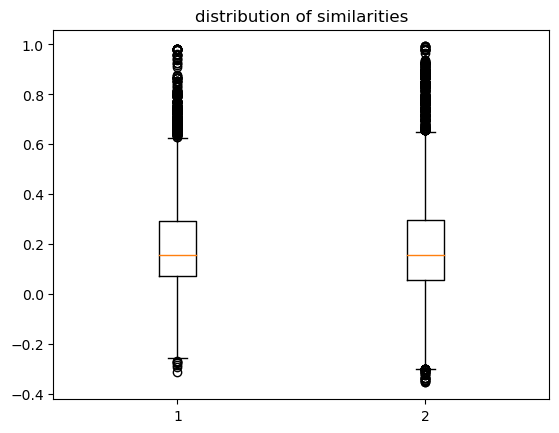

In [12]:
plt.boxplot([result_with_name, result_without_name])
plt.title("distribution of similarities")

Text(0.5, 1.0, 'Similarity between inputs and outputs')

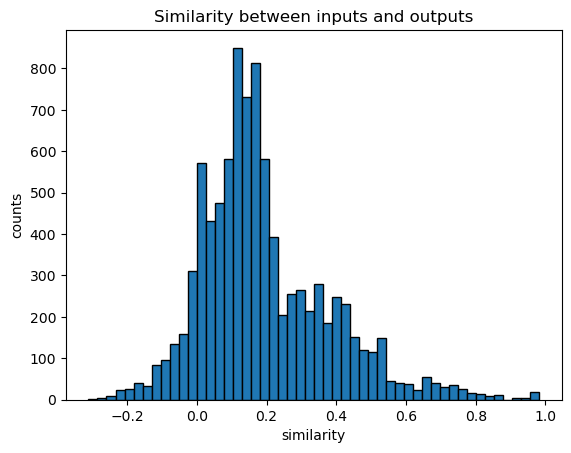

In [13]:
plt.hist(result_with_name, bins=50, edgecolor='black')
plt.xlabel("similarity")
plt.ylabel("counts")
plt.title("Similarity between inputs and outputs")


# checking individual cases

In [14]:
indices = [index for index, value in enumerate(result_with_name) if result_with_name[index] < 0.2]

i = 2
print(df['input'][indices[i]], " <-> ",df['output'][indices[i]])

GE2 EXH GAS TEMP. CYL OUTLET 9 (TE25_9)  <->  DE2Thing<SEP>Cy9ExhGasOutletTemp


In [17]:
indices = [index for index, value in enumerate(result_with_name) if (result_with_name[index] > 0.2 and result_with_name[index] < 0.5)]

i = 2
print(df['input'][indices[i]], " <-> ",df['output'][indices[i]])

NO.1 BALLAST PUMP CURRENT  <->  ElectricEnergyConsumeThing<SEP>BallastPump1_Current


In [18]:
indices = [index for index, value in enumerate(result_with_name) if result_with_name[index] <0.8]

i = 2
print(df['input'][indices[i]], " <-> ",df['output'][indices[i]])

ENGINE ROOM PRESSURE  <->  ERThing<SEP>AirPress
